In [1]:

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns

import scipy.io as sio
from scipy import linalg

import firedrake as fd
import hydrogym as gym

fd.utils.ScalarType

dtype('float64')

In [2]:
mesh = 'noack'
evec_dir = 'global-modes'
flow = gym.flow.Cylinder(Re=40, h5_file=f'{evec_dir}/steady.h5')
print(flow.dot(flow.q, flow.q))

212.86945874512767


In [3]:
# flow = gym.flow.Cylinder(Re=50, mesh_name=mesh, h5_file=f'../output/{mesh}-steady.h5')
qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


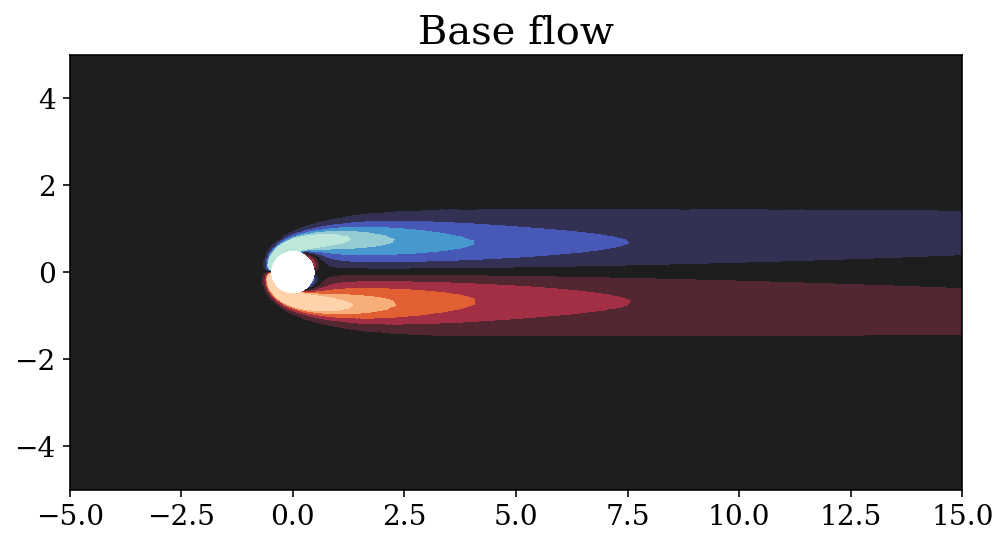

In [4]:
vort = flow.vorticity(u=qB.sub(0))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-2, 2, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.title("Base flow")
plt.show()

0.0010106718443669397


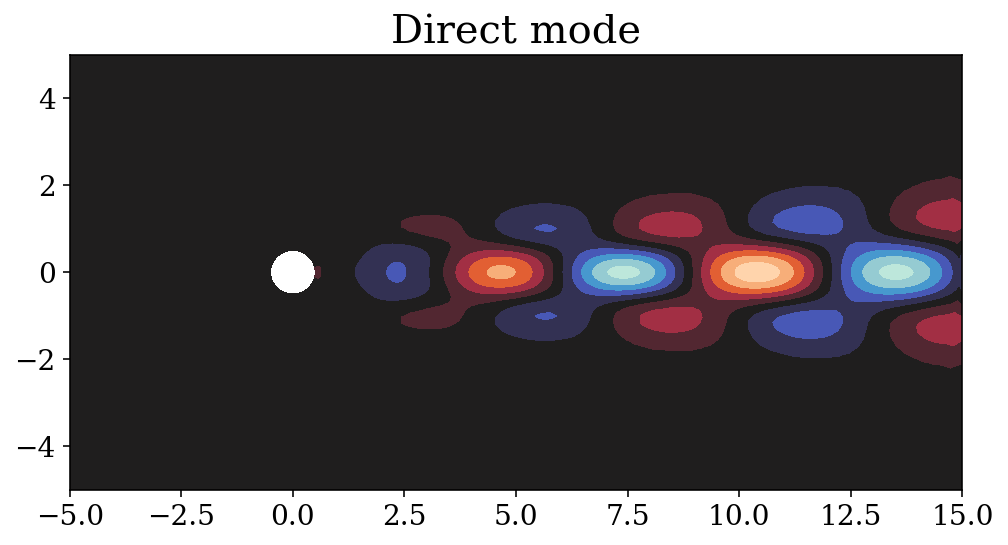

0.0004448831010784385


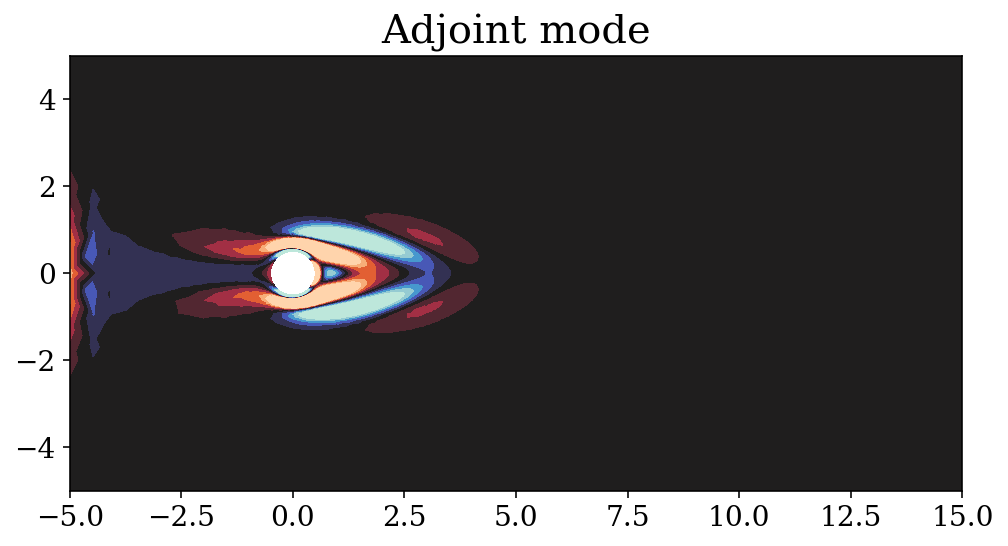

In [5]:
flow.load_checkpoint(f'{evec_dir}/direct_real.h5', idx=0, read_mesh=False)
print(flow.dot(flow.q, flow.q))
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.title("Direct mode")
plt.show()

flow.load_checkpoint(f'{evec_dir}/adjoint_real.h5', idx=0, read_mesh=False)
print(flow.dot(flow.q, flow.q))
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.title("Adjoint mode")
plt.show()

# Petrov-Galerkin projection

In [335]:
# Construct modal basis from real/imag parts
with flow.q.dat.vec_ro as vec:
    N = vec.size
V = np.zeros((N, 2))
W = np.zeros_like(V)

flow.load_checkpoint(f'{evec_dir}/direct_real.h5', idx=0, read_mesh=False)
V[:, 0] = gym.utils.get_array(flow.q)
    
flow.load_checkpoint(f'{evec_dir}/direct_imag.h5', idx=0, read_mesh=False)
V[:, 1] = gym.utils.get_array(flow.q)
    
flow.load_checkpoint(f'{evec_dir}/adjoint_real.h5', idx=0, read_mesh=False)
W[:, 0] = gym.utils.get_array(flow.q)

flow.load_checkpoint(f'{evec_dir}/adjoint_imag.h5', idx=0, read_mesh=False)
W[:, 1] = gym.utils.get_array(flow.q)

M = flow.mass_matrix(backend='scipy')

In [336]:
# Construct action of "A" and "C" on basis vectors
solver = gym.ts.IPCS(flow, dt=1e-2)
A, B = solver.linearize(qB)

r = 2
y_dim = 2
A_on_basis_vecs = np.zeros((N, r))
C_on_basis_vecs = np.zeros((y_dim, r))
for i in range(r):
    A_on_basis_vecs[:, i] = A * V[:, i]

    gym.utils.set_from_array(flow.q, V[:, i])
    C_on_basis_vecs[:, i] = flow.collect_observations()

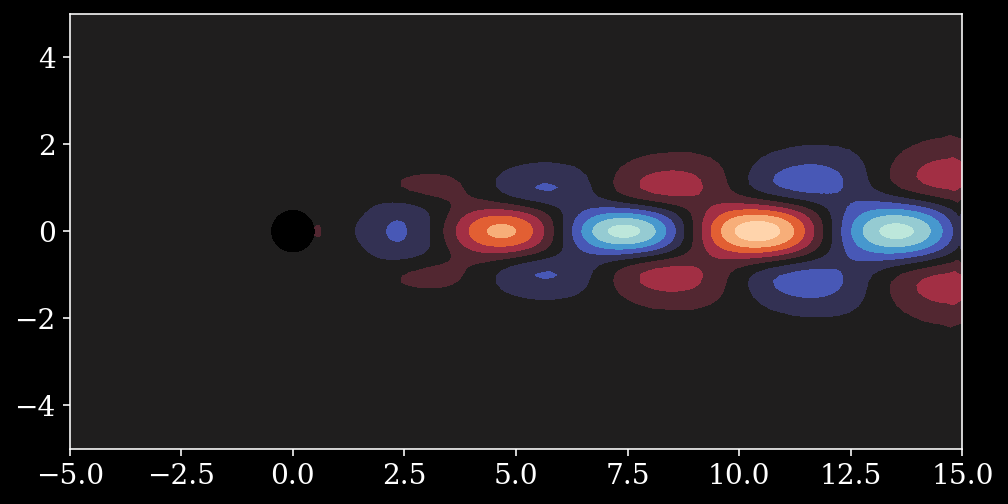

In [346]:
gym.utils.set_from_array(flow.q, A_on_basis_vecs[:, 0])
vort = flow.vorticity()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [342]:
P = linalg.inv(W.T @ M @ V) @ (W.T @ M)
Ar = P @ A_on_basis_vecs
Br = P @ B
Cr = C_on_basis_vecs

In [343]:
dt_evals, _ = linalg.eig(Ar)
np.log(dt_evals)/1e-2

array([-0.02636112+0.8404688j, -0.02636112-0.8404688j])

# LQG design

In [344]:
import control

### Feedback control

In [345]:
Q = np.eye(r)
R = 1e8
K, _, ctrl_evals = control.dlqr(Ar, Br, Q, R)

np.log(ctrl_evals)/1e-2

array([-0.02636112+0.8404688j, -0.02636112-0.8404688j])

In [346]:
Br

array([[-0.00069867],
       [ 0.00039018]])

In [347]:
K

array([[-1.33130713e-08,  7.28823246e-09]])

### Observer system

In [348]:
QN = 1e-6*np.eye(r)
RN = 1e-6*np.eye(y_dim)
GN = np.eye(r)

L, _, _ = control.dlqe(Ar, GN, Cr, QN, RN)

In [349]:
L

array([[ 2.65576980e-01,  2.79018637e-06],
       [-9.38325360e-01,  2.47814458e-05]])

In [350]:
Cr

array([[ 2.48852371e-04, -9.51824936e-04],
       [ 3.14440860e-09,  2.54539693e-08]])

### Test on ROM

In [351]:
Tf = 100
dt = 1e-2
n_steps = int(Tf//dt)

x = np.zeros((r, n_steps))
y = np.zeros((y_dim, n_steps))
x_hat = np.zeros((r, n_steps))
q = 1e-2*V[:, 0]

# Initialize
P = WV_inv @ (W.T @ M)
x[:, 0] = P @ (1e-2*V[:, 0])
# x_hat[:, 0] = x[:, 0]

for i in range(1, n_steps):
    x[:, i] = Ar @ x[:, i-1]
    y[:, i] = Cr @ x[:, i]
    
    err = y[:, i] - Cr @ x_hat[:, i-1]
    x_hat[:, i] = Ar @ x_hat[:, i-1] + L @ err
    
    print(i, x[:, i], y[:, i], x_hat[:, i], np.linalg.norm(err))

1 [-0.00755422  0.00247879] [-4.23925867e-06  3.93414392e-11] [-1.12584952e-06  3.97780392e-06] 4.239258669207893e-06
2 [-0.00753114  0.00254152] [-4.29322335e-06  4.10107599e-11] [-2.23119174e-06  8.01069730e-06] 4.289157002619629e-06
3 [-0.00750754  0.00260404] [-4.34685609e-06  4.26763018e-11] [-3.31546918e-06  1.20981355e-05] 4.3386760753096644e-06
4 [-0.00748342  0.00266634] [-4.40015330e-06  4.43379491e-11] [-4.37812831e-06  1.62395664e-05] 4.387812928143024e-06
5 [-0.00745878  0.00272842] [-4.45311137e-06  4.59955863e-11] [-5.4186196e-06  2.0434431e-05] 4.436564633571682e-06
6 [-0.00743363  0.00279027] [-4.50572673e-06  4.76490984e-11] [-6.43639766e-06  2.46821629e-05] 4.484928295795883e-06
7 [-0.00740797  0.0028519 ] [-4.55799586e-06  4.92983707e-11] [-7.43092123e-06  2.89821885e-05] 4.532901050922969e-06
8 [-0.0073818   0.00291329] [-4.60991524e-06  5.09432888e-11] [-8.40165327e-06  3.33339273e-05] 4.580480067123702e-06
9 [-0.00735512  0.00297444] [-4.66148138e-06  5.25837388e

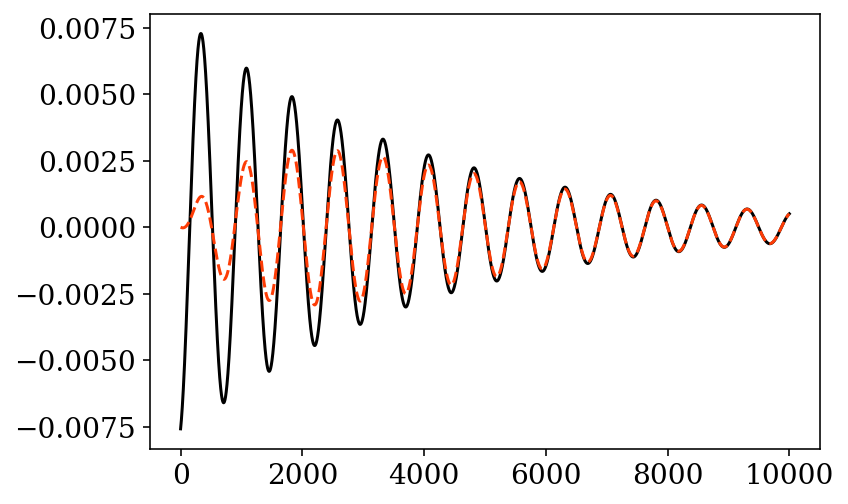

In [352]:
plt.plot(x[0, :], c='k')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange')

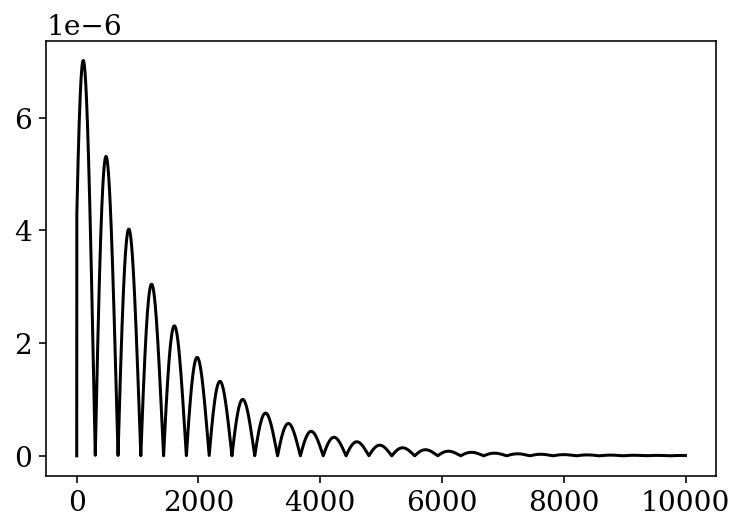

In [353]:
err =  y - Cr @ x_hat
# err = x - x_hat
plt.plot(np.sqrt(np.sum(err**2, axis=0)), c='k')

In [370]:
# With control

Tf = 100
dt = 1e-2
n_steps = int(Tf//dt)

x = np.zeros((r, n_steps))
y = np.zeros((y_dim, n_steps))
x_hat = np.zeros((r, n_steps))
q = 1e-2*V[:, 0]

# Initialize
P = WV_inv @ (W.T @ M)
x[:, 0] = P @ (1e-2*V[:, 0])
# x_hat[:, 0] = x[:, 0]

for i in range(1, n_steps):
    u = -(K @ x_hat[:, i-1])
    u = 1e0
    x[:, i] = Ar @ x[:, i-1] + Br[:, 0]*u
    y[:, i] = Cr @ x[:, i]
    
    err = y[:, i] - Cr @ x_hat[:, i-1]
    x_hat[:, i] = Ar @ x_hat[:, i-1] + Br[:, 0]*u + L @ err
    
    print(i, x[:, i], y[:, i], x_hat[:, i], np.linalg.norm(err))

1 [-0.00825289  0.00286897] [-4.78450953e-06  4.70762156e-11] [-0.00069994  0.00039467] 4.784509533493283e-06
2 [-0.008925    0.00332764] [-5.38833377e-06  5.66377291e-11] [-0.00139637  0.00079516] 4.838493554001747e-06
3 [-0.00959304  0.00379181] [-5.99639348e-06  6.63522393e-11] [-0.00208924  0.00120142] 4.892053164712365e-06
4 [-0.01025699  0.00426146] [-6.60864345e-06  7.62189787e-11] [-0.00277851  0.00161344] 4.945185186141376e-06
5 [-0.0109168   0.00473655] [-7.22503818e-06  8.62371696e-11] [-0.00346412  0.00203118] 4.997886473946836e-06
6 [-0.01157241  0.00521704] [-7.84553192e-06  9.64060242e-11] [-0.00414603  0.00245459] 5.05015391910008e-06
7 [-0.01222379  0.0057029 ] [-8.47007865e-06  1.06724744e-10] [-0.0048242   0.00288366] 5.10198444805442e-06
8 [-0.0128709   0.00619408] [-9.09863208e-06  1.17192521e-10] [-0.00549857  0.00331835] 5.153375022911067e-06
9 [-0.01351368  0.00669055] [-9.73114567e-06  1.27808536e-10] [-0.0061691   0.00375863] 5.2043226415822705e-06
10 [-0.0141

In [371]:
Br

array([[-0.00069867],
       [ 0.00039018]])

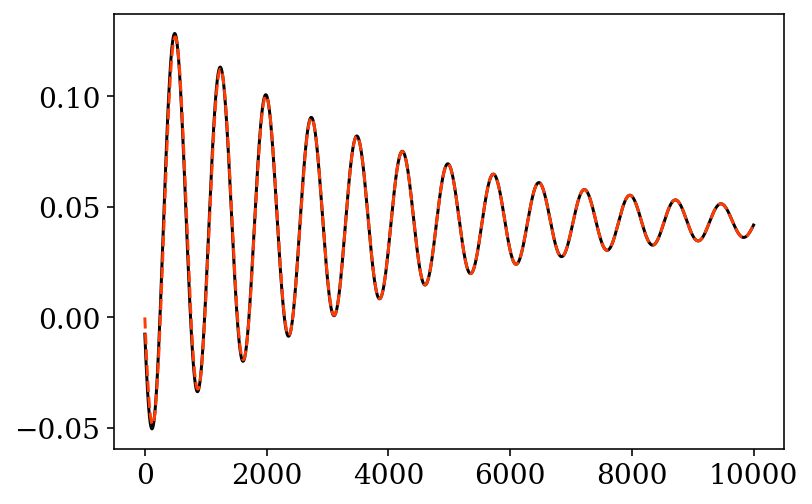

In [372]:
plt.plot(x[0, :], c='k')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange')

# Load results from LTI timestepping

In [276]:
data = sio.loadmat('discrete/lti-kalman.mat')

In [277]:
x = data['x']
y = data['y']
x_hat = data['x_hat']

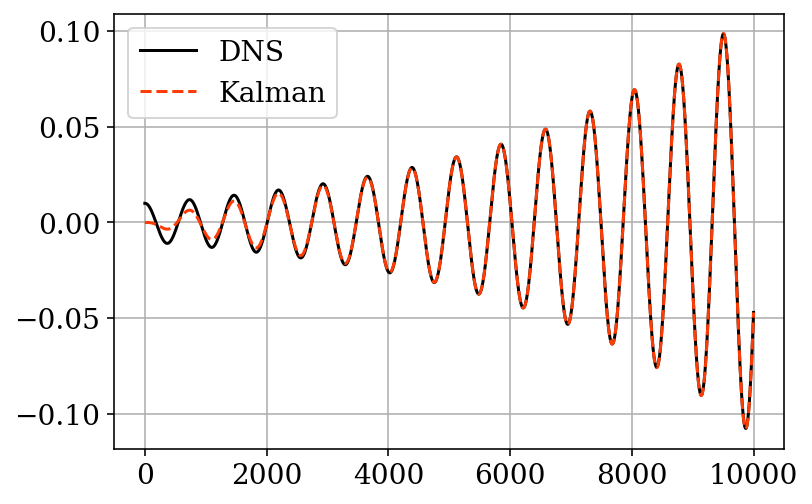

In [278]:
plt.plot(x[0, :], c='k', label='DNS')
plt.plot(x_hat[0, :], '--', c='xkcd:red orange', label='Kalman')
plt.legend(fontsize=14)
plt.grid()

### With control

In [288]:
data = sio.loadmat('discrete/lti-ctrl.mat')
x = data['x']
y = data['y']
u = data['u']
x_hat = data['x_hat']

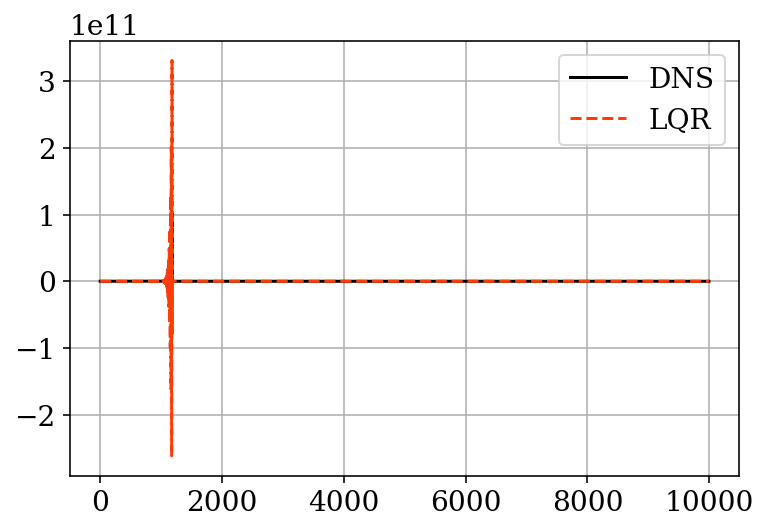

In [289]:
plt.plot(x[0, 2:].T, c='k', label='DNS')
plt.plot(x_hat[0, 2:].T, '--', c='xkcd:red orange', label='LQR')
plt.legend(fontsize=14)
# plt.ylim([-0.1, 0.1])
# plt.xlim([0, 1000])
plt.grid()

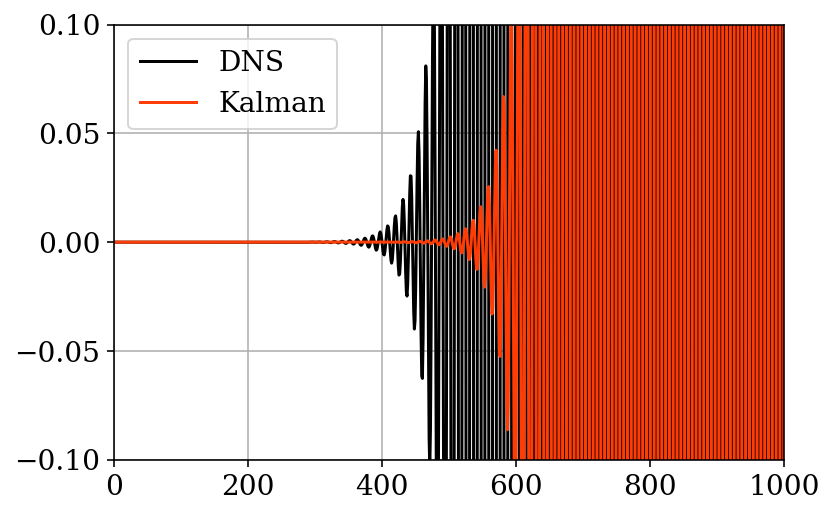

In [291]:
y_hat = Cr @ x_hat
plt.plot(y[0, 2:], c='k', label='DNS')
plt.plot(y_hat[0, 2:], c='xkcd:red orange', label='Kalman')
plt.legend(fontsize=14)
plt.ylim([-0.1, 0.1])
plt.xlim([0, 1000])
plt.grid()

In [38]:
# plt.plot(x[0, 2:], c='k', label='DNS')
plt.plot(u[0, 2:], '-', c='xkcd:red orange', label='Control')
plt.legend(fontsize=14)
# plt.ylim([-0.1, 0.1])
# plt.xlim([0, 1000])
plt.grid()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# PD control

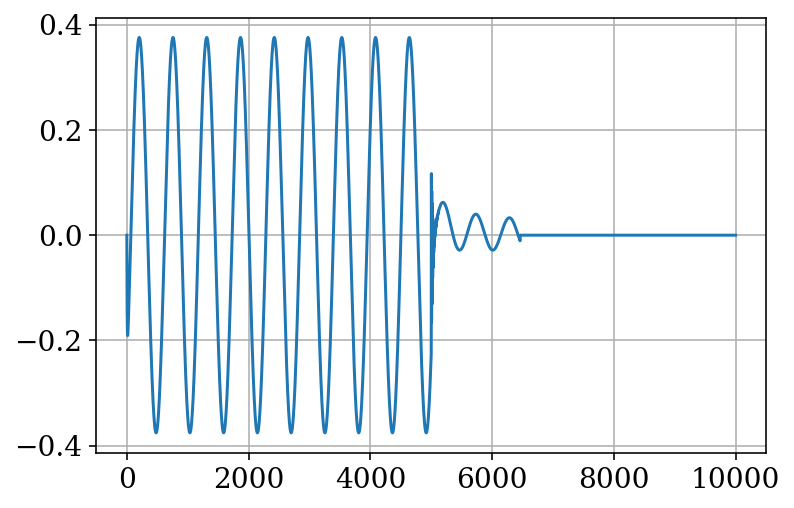

In [44]:
data = sio.loadmat('../output/pd-control.mat')

u = data['u'][0]
y = data['y'][0]

plt.plot(y)
# plt.xlim([0, 1000])
plt.grid()
plt.show()

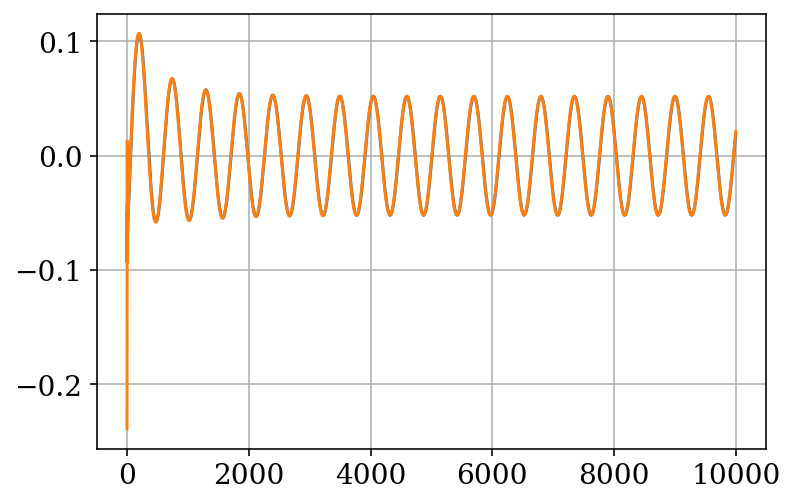

In [42]:

plt.plot(data_pd2['y'][0])
plt.plot(data_pd2['y_hat'][0])
# plt.xlim([0, 1000])
plt.grid()
plt.show()

In [ ]:


u = data['u'][0]
y = data['y'][0]
y_hat = data['y_hat'][0]

plt.plot(y, c='k')
plt.plot(y_hat, c='r')
plt.xlim([0, 1000])
plt.grid()
plt.show()

plt.plot(u, c='k')
plt.xlim([0, 1000])
plt.grid()
plt.show()

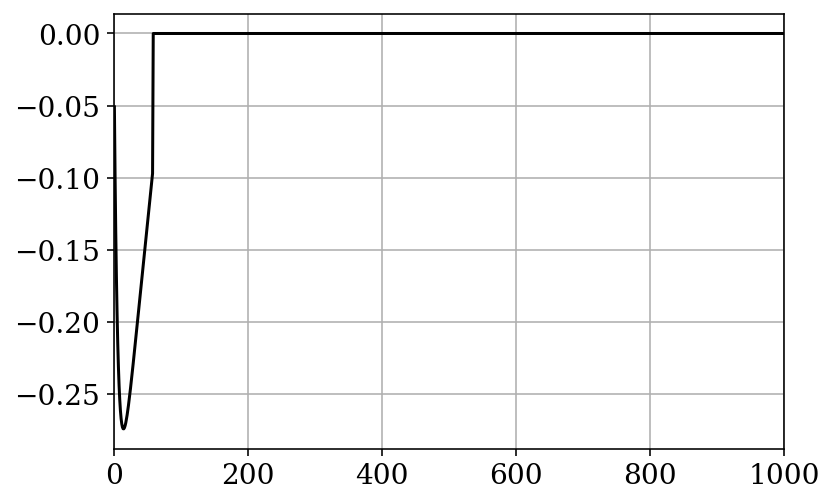